In [2]:
# Import required modules
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
project_root = str(Path.cwd().resolve().parent)
print(f"Project root: {project_root}")

Project root: C:\Users\Nitya Karthik A\ds4cg-job-analytics


In [4]:
# Add project root to sys.path for module imports
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.analysis import efficiency_analysis as ea
from src.visualization import JobsWithMetricsVisualizer, UsersWithMetricsVisualizer

# Automatically reload modules before executing code
# This is useful for development to see changes without restarting the kernel.
%load_ext autoreload
# Reload all modules imported with %aimport every time before executing the Python code typed.
%autoreload 2

In [5]:
# Load the jobs DataFrame from DuckDB
preprocessed_jobs_df = ea.load_preprocessed_jobs_dataframe_from_duckdb(
    db_path='../data/slurm_data.db',
    table_name='Jobs',
    )
display(preprocessed_jobs_df.head(10))
print(preprocessed_jobs_df.shape)

Connected to ../data/slurm_data.db
[Preprocessing] Running with new database format: GPU types as dictionary.
Disconnected from ../data/slurm_data.db


,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,...,GPUComputeUsage,CPUMemUsage,CPUComputeUsage,Queued,vram_constraint,partition_constraint,requested_vram,allocated_vram,user_jobs,account_jobs
2,38482061,<NA>,-1,joby42h-n,False,non-interactive,pi_zhangl_uri_edu,zhangl_uri_edu,['avx512'],long,...,0.0,2.576670e+10,99.143585,3 days 01:23:00,<NA>,<NA>,<NA>,320,959,1309
22,38634311,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,['2080ti'],normal,...,88.0,5.945262e+08,99.912697,0 days 00:00:18,<NA>,<NA>,<NA>,11,118912,118912
23,38634905,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,['2080ti'],normal,...,88.0,6.020669e+08,99.949554,0 days 00:00:31,<NA>,<NA>,<NA>,11,118912,118912
24,38634906,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,['2080ti'],normal,...,90.0,6.128353e+08,99.956528,0 days 00:00:20,<NA>,<NA>,<NA>,11,118912,118912
25,38634956,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,['2080ti'],normal,...,90.0,5.236490e+08,99.956741,0 days 00:00:26,<NA>,<NA>,<NA>,11,118912,118912
26,38634965,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,['2080ti'],normal,...,89.0,6.643016e+08,99.956139,0 days 00:00:17,<NA>,<NA>,<NA>,11,118912,118912
27,38641028,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,['2080ti'],normal,...,90.0,5.166858e+08,99.957039,0 days 00:00:13,<NA>,<NA>,<NA>,11,118912,118912
75,38689004,<NA>,-1,emri,False,non-interactive,pi_gkhanna_uri_edu,gkhanna_uri_edu,[],normal,...,0.0,6.888489e+08,6.247138,0 days 00:00:19,<NA>,16,16,16,4507,9657
76,38689007,<NA>,-1,emri,False,non-interactive,pi_gkhanna_uri_edu,gkhanna_uri_edu,[],normal,...,0.0,7.478968e+08,6.247185,0 days 00:00:03,<NA>,16,16,16,4507,9657
77,38689021,<NA>,-1,emri,False,non-interactive,pi_gkhanna_uri_edu,gkhanna_uri_edu,[],normal,...,0.0,7.148012e+08,6.247218,0 days 00:00:08,<NA>,16,16,16,4507,9657


(1120587, 33)


In [6]:
#filter out jobs with 1 GPU 
preprocessed_jobs_df = preprocessed_jobs_df[preprocessed_jobs_df['GPUs'] == 1]
preprocessed_jobs_df

,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,...,GPUComputeUsage,CPUMemUsage,CPUComputeUsage,Queued,vram_constraint,partition_constraint,requested_vram,allocated_vram,user_jobs,account_jobs
22,38634311,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,['2080ti'],normal,...,88.0,5.945262e+08,99.912697,0 days 00:00:18,<NA>,<NA>,<NA>,11,118912,118912
23,38634905,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,['2080ti'],normal,...,88.0,6.020669e+08,99.949554,0 days 00:00:31,<NA>,<NA>,<NA>,11,118912,118912
24,38634906,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,['2080ti'],normal,...,90.0,6.128353e+08,99.956528,0 days 00:00:20,<NA>,<NA>,<NA>,11,118912,118912
25,38634956,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,['2080ti'],normal,...,90.0,5.236490e+08,99.956741,0 days 00:00:26,<NA>,<NA>,<NA>,11,118912,118912
26,38634965,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,['2080ti'],normal,...,89.0,6.643016e+08,99.956139,0 days 00:00:17,<NA>,<NA>,<NA>,11,118912,118912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11123780,40134095,<NA>,-1,a775a96d-ca15-43de-a940-c8cd33d32927,False,non-interactive,pi_drsheldon_umass_edu,mmfuentes_umass_edu,"['2080ti', 'rtx8000', 'a40']",normal,...,100.0,4.271239e+09,71.917648,0 days 00:13:48,48,<NA>,48,11,6460,126128
11123781,40134096,<NA>,-1,main.sh,False,non-interactive,pi_mchiovaro_uri_edu,shivav_uri_edu,[],normal,...,49.0,5.861458e+08,98.984322,0 days 00:00:09,<NA>,<NA>,<NA>,12,32,235
11123782,40134099,<NA>,-1,a775a96d-ca15-43de-a940-c8cd33d32927,False,non-interactive,pi_drsheldon_umass_edu,mmfuentes_umass_edu,"['2080ti', 'rtx8000', 'a40']",normal,...,100.0,4.313879e+09,61.508465,0 days 00:14:41,48,<NA>,48,11,6460,126128
11123793,40134111,<NA>,-1,nrsur_redos.sh,False,non-interactive,pi_mpuerrer_uri_edu,samuel_clyne_uri_edu,['gpu:l40s'],normal,...,10.0,9.411617e+09,2.270639,0 days 00:00:12,48,80,80,48,893,916


In [10]:
#get total number of jobs in preprocessed_jobs_df per partition and get total number of vram_hours per partition
value_counts = preprocessed_jobs_df['Partition'].value_counts()
efficiency_analysis_obj = ea.EfficiencyAnalysis(preprocessed_jobs_df)
# Calculate VRAM hours for each partition
vram_hours_per_partition = efficiency_analysis_obj.calculate_job_efficiency_metrics(filtered_jobs=preprocessed_jobs_df).groupby('Partition')['vram_hours'].sum()
#sort partitions by vram_hours
vram_hours_per_partition = vram_hours_per_partition.sort_values(ascending=False)

print(vram_hours_per_partition)


Partition
gpu-preempt               24838836.150833
gpu                       24424844.781667
superpod-a100              7730271.488889
uri-gpu                        3269931.32
gpupod-l40s                     2192933.6
ials-gpu                   1981301.237778
gpu-long                     1500394.0525
gypsum-rtx8000                 1410025.88
power9-gpu                 1141204.111111
umd-cscdr-gpu               974775.662222
gypsum-1080ti               960221.637222
gypsum-2080ti               777541.013333
power9-gpu-preempt          218324.226667
gypsum-titanx               183213.623333
lan                         138969.306667
gypsum-m40                  102324.233611
arm-gpu                     101137.554167
cbio-gpu                           4702.6
astroth-gpu                     74.571111
zhoulin-cpu                           0.0
ceewater_cjgleason-cpu                0.0
cpu-preempt                           0.0
jdelhommelle                          0.0
power9                  

C:\Users\Nitya Karthik A\AppData\Local\Temp\ipykernel_19308\2951792259.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vram_hours_per_partition = efficiency_analysis_obj.calculate_job_efficiency_metrics(filtered_jobs=preprocessed_jobs_df).groupby('Partition')['vram_hours'].sum()


In [8]:
#get all unique partitions 
partitions = preprocessed_jobs_df['Partition'].unique()
partitions = partitions.remove_categories(['arm-gpu', 'gpu', 'gpu-preempt', 'power9-gpu', 'power9-gpu-preempt'])
print(partitions.categories)

Index(['arm-preempt', 'astroth-cpu', 'astroth-gpu', 'building', 'cbio-cpu',
       'cbio-gpu', 'ceewater_casey-cpu', 'ceewater_cjgleason-cpu',
       'ceewater_kandread-cpu', 'cpu', 'cpu-preempt', 'ece-gpu', 'fsi-lab',
       'gaoseismolab-cpu', 'gpu-long', 'gpupod-l40s', 'gypsum-1080ti',
       'gypsum-2080ti', 'gypsum-m40', 'gypsum-rtx8000', 'gypsum-titanx',
       'ials-gpu', 'jdelhommelle', 'lan', 'mpi', 'power9', 'power9-gpu-osg',
       'superpod-a100', 'toltec-cpu', 'umd-cscdr-arm', 'umd-cscdr-cpu',
       'umd-cscdr-gpu', 'uri-cpu', 'uri-gpu', 'uri-richamp', 'visterra',
       'zhoulin-cpu'],
      dtype='object')


In [125]:
# #for each unique partition, get the vram constraint they are setting 
# result = preprocessed_jobs_df.groupby('Partition')['vram_constraint'].unique()
# print("VRAM constraints for each partition:")
# for partition, constraints in result.items():
#     print(f"Partition: {partition}, VRAM Constraints: {constraints}")

filtered_df = preprocessed_jobs_df[preprocessed_jobs_df['vram_constraint'] == 640]
print(f"Filtered DataFrame: {filtered_df['vram_constraint']}")


Filtered DataFrame: Series([], Name: vram_constraint, dtype: Int64)


In [126]:
from tabulate import tabulate

def generate_statistics_on_vram_constraints_per_partition(df, partition_name):
    """
    Generate a clean tabular summary of job counts by VRAM constraint for a partition.
    """
    partition_data = df[df['Partition'] == partition_name]
    
    if partition_data.empty:
        print(f"No data found for partition: {partition_name}")
        return

    vram_counts = partition_data['vram_constraint'].value_counts().sort_index()
    
    table_data = [(vram, count) for vram, count in vram_counts.items()]
    headers = ["VRAM Constraint (GB)", "Job Count"]
    
    print(f"\nSummary for Partition '{partition_name}':\n")
    print(tabulate(table_data, headers=headers, tablefmt="pretty"))

In [127]:
generate_statistics_on_vram_constraints_per_partition(preprocessed_jobs_df, 'superpod-a100')

for partition in partitions.categories:
    generate_statistics_on_vram_constraints_per_partition(preprocessed_jobs_df, partition)


Summary for Partition 'superpod-a100':

+----------------------+-----------+
| VRAM Constraint (GB) | Job Count |
+----------------------+-----------+
|          12          |    10     |
|          16          |    77     |
|          23          |    259    |
|          32          |    26     |
|          40          |   8790    |
|          48          |    291    |
|          80          |   3358    |
|          95          |    98     |
+----------------------+-----------+
No data found for partition: arm-preempt
No data found for partition: astroth-cpu

Summary for Partition 'astroth-gpu':

+----------------------+-----------+
| VRAM Constraint (GB) | Job Count |
+----------------------+-----------+
+----------------------+-----------+
No data found for partition: building
No data found for partition: cbio-cpu

Summary for Partition 'cbio-gpu':

+----------------------+-----------+
| VRAM Constraint (GB) | Job Count |
+----------------------+-----------+
+----------------------

In [128]:
def plot_percentage_stacked_vram_by_partition(df) -> None:
    """
    Create a percentage stacked bar plot (all bars have same height, showing proportions).
    """
    df_filtered = df[~df['Partition'].isin(['gpu', 'gpu-preempt', 'power9-gpu', 'power9-gpu-preempt', 'arm-gpu'])]
    df_filtered = df[df['Partition'].isin(['superpod-a100', 'uri-gpu'])]

    # Create a pivot table
    pivot_data = df_filtered.groupby(['Partition', 'vram_constraint']).size().unstack(fill_value=0)
    
    # Convert to percentages
    pivot_percentage = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100
    pivot_percentage = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100

# Remove rows with no data
    pivot_percentage = pivot_percentage[pivot_percentage.sum(axis=1) > 0]

    
    # Create the plot
    fig, ax = plt.subplots(figsize=(max(8, len(pivot_data) * 1.2), 8))
    
    # Create stacked bars
    bottom = np.zeros(len(pivot_percentage))
    colors = plt.cm.Set3(np.linspace(0, 1, len(pivot_percentage.columns)))
    
    for i, (vram_constraint, color) in enumerate(zip(pivot_percentage.columns, colors)):
        values = pivot_percentage[vram_constraint].values
        bars = ax.bar(range(len(pivot_percentage)), values, bottom=bottom,
                     label=f'{int(vram_constraint)}GB', color=color, width=0.7)
        
        # Add percentage labels
        for bar, value in zip(bars, values):
            if value > 5:  # Only label segments >5%
                ax.text(bar.get_x() + bar.get_width()/2, 
                       bottom[bars.index(bar)] + value/2,
                       f'{value:.1f}%', ha='center', va='center', 
                       fontsize=9, fontweight='bold')
        
        bottom += values
    
    # Customize the plot
    ax.set_title('VRAM Constraint Distribution by Partition (Percentage)', fontsize=14, pad=20)
    ax.set_xlabel('GPU Partition', fontsize=12)
    ax.set_ylabel('Percentage of Jobs', fontsize=12)
    
    # Set x-axis labels
    ax.set_xticks(range(len(pivot_percentage)))
    ax.set_xticklabels(pivot_percentage.index, rotation=45 if len(pivot_percentage) > 5 else 0)
    
    # Add legend
    ax.legend(title='VRAM Constraint', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Set y-axis to 0-100%
    ax.set_ylim(0, 100)
    ax.grid(axis='y', alpha=0.3)
    ax.set_axisbelow(True)
    
    plt.tight_layout()
    plt.show()


Available partitions: ['gpu', 'power9-gpu-preempt', 'umd-cscdr-gpu', 'gpu-preempt', 'gpupod-l40s', ..., 'gypsum-2080ti', 'gypsum-1080ti', 'gypsum-m40', 'gypsum-titanx', 'gpu-long']
Length: 19
Categories (42, object): ['zhoulin-cpu', 'gpu-long', 'gypsum-titanx', 'ceewater_cjgleason-cpu', ..., 'power9-gpu-osg', 'astroth-cpu', 'gypsum-rtx8000', 'ials-gpu']


C:\Users\Nitya Karthik A\AppData\Local\Temp\ipykernel_23036\3438579651.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot_data = df_filtered.groupby(['Partition', 'vram_constraint']).size().unstack(fill_value=0)


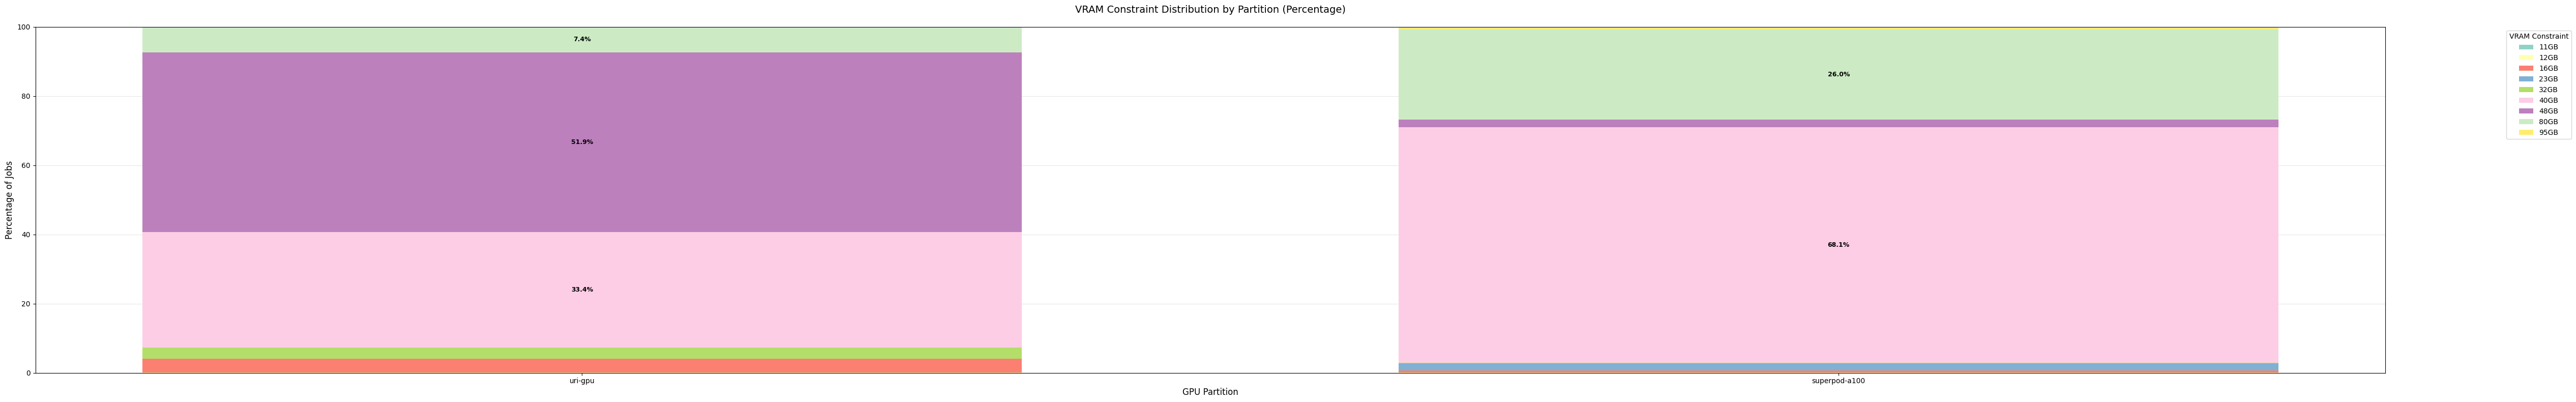

In [129]:
# Usage:
print("Available partitions:", preprocessed_jobs_df['Partition'].unique())


# Or create percentage stacked bar plot
plot_percentage_stacked_vram_by_partition(preprocessed_jobs_df)


In [130]:
def plot_percentage_stacked_vram_by_partition(df) -> None:
    """
    Create a percentage stacked bar plot in two rows to improve readability.
    """

    # Filter to only relevant partitions
    df_filtered = df[~df['Partition'].isin(['gpu', 'gpu-preempt', 'power9-gpu', 'power9-gpu-preempt', 'arm-gpu'])]
    # Pivot and convert to percentage
    pivot_data = df_filtered.groupby(['Partition', 'vram_constraint']).size().unstack(fill_value=0)
    pivot_percentage = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100
    pivot_percentage = pivot_percentage[pivot_percentage.sum(axis=1) > 0]

    if pivot_percentage.empty:
        print("No data to plot.")
        return

    # Split into two groups
    mid = len(pivot_percentage) // 2 + len(pivot_percentage) % 2
    top_half = pivot_percentage.iloc[:mid]
    bottom_half = pivot_percentage.iloc[mid:]

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(max(10, len(pivot_percentage) * 1.2), 10), sharey=True)

    for ax, data in zip(axes, [top_half, bottom_half]):
        bottom = np.zeros(len(data))
        colors = plt.cm.Set3(np.linspace(0, 1, len(data.columns)))

        for vram_constraint, color in zip(data.columns, colors):
            values = data[vram_constraint].values
            bars = ax.bar(range(len(data)), values, bottom=bottom,
                          label=f'{int(vram_constraint)}GB', color=color, width=0.7)

            # Add percentage labels
            for bar, value in zip(bars, values):
                if value > 5:
                    ax.text(bar.get_x() + bar.get_width() / 2,
                            bottom[list(bars).index(bar)] + value / 2,
                            f'{value:.1f}%', ha='center', va='center',
                            fontsize=11, fontweight='bold')

            bottom += values

        ax.set_xticks(range(len(data)))
        ax.set_xticklabels(data.index, rotation=45 if len(data) > 5 else 0, fontsize=12)
        ax.tick_params(axis='y', labelsize=12)
        ax.grid(axis='y', alpha=0.3)
        ax.set_axisbelow(True)

    axes[0].set_title('VRAM Constraint Distribution by Partition (Percentage)', fontsize=16, pad=20)
    axes[1].set_xlabel('GPU Partition', fontsize=14)
    axes[0].set_ylabel('Percentage of Jobs', fontsize=14)
    axes[1].set_ylabel('Percentage of Jobs', fontsize=14)

    # Add legend only once
    axes[0].legend(title='VRAM Constraint', title_fontsize=13, fontsize=11,
                   bbox_to_anchor=(1.05, 1), loc='upper left')

    for ax in axes:
        ax.set_ylim(0, 100)

    plt.tight_layout()
    plt.show()

Available partitions: ['gpu', 'power9-gpu-preempt', 'umd-cscdr-gpu', 'gpu-preempt', 'gpupod-l40s', ..., 'gypsum-2080ti', 'gypsum-1080ti', 'gypsum-m40', 'gypsum-titanx', 'gpu-long']
Length: 19
Categories (42, object): ['zhoulin-cpu', 'gpu-long', 'gypsum-titanx', 'ceewater_cjgleason-cpu', ..., 'power9-gpu-osg', 'astroth-cpu', 'gypsum-rtx8000', 'ials-gpu']


C:\Users\Nitya Karthik A\AppData\Local\Temp\ipykernel_23036\1347687151.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot_data = df_filtered.groupby(['Partition', 'vram_constraint']).size().unstack(fill_value=0)


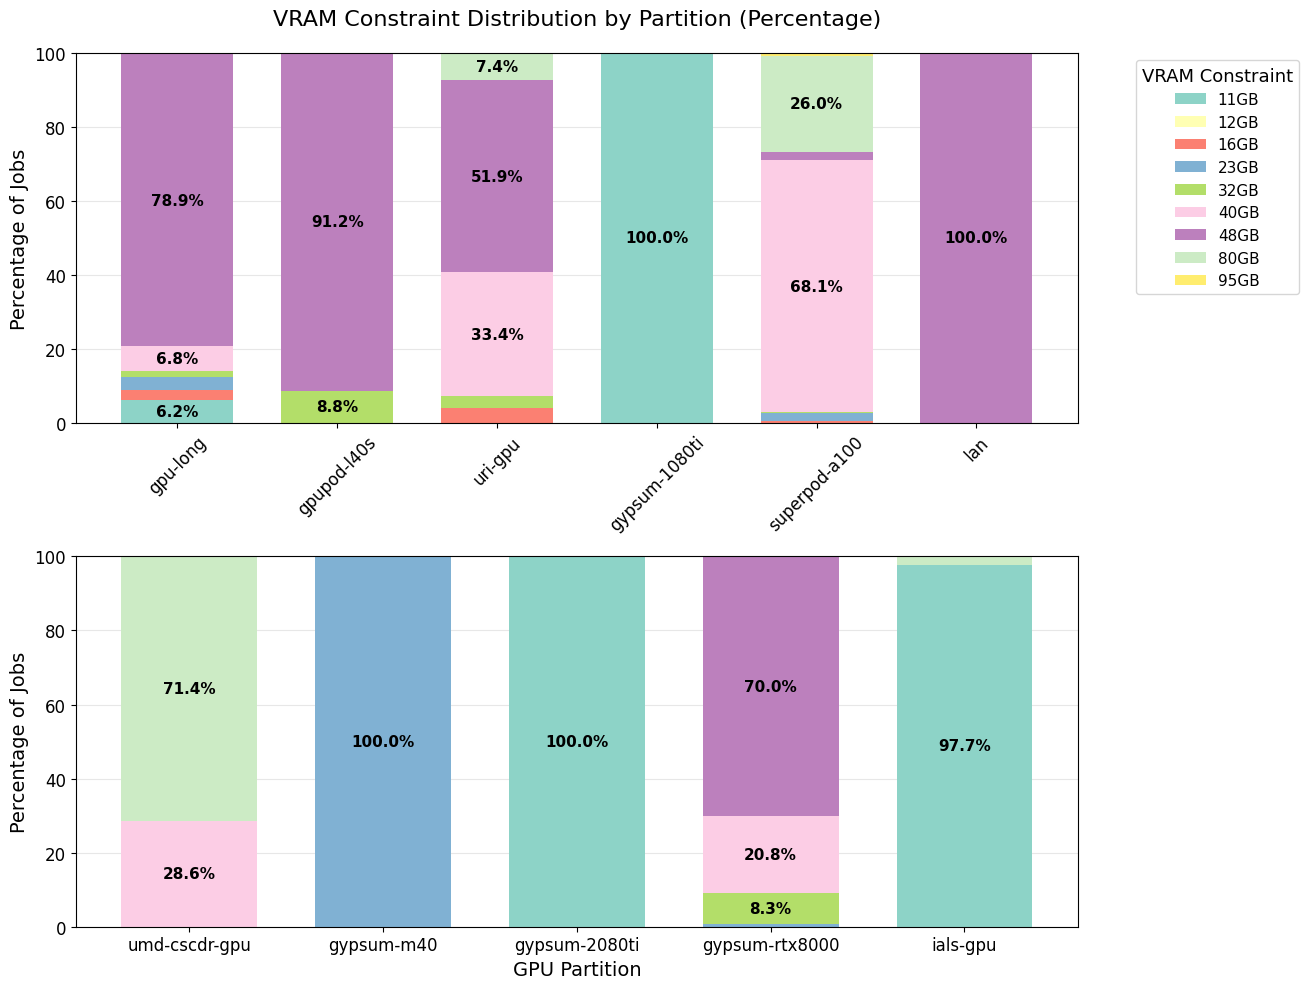

In [131]:
# Usage:
print("Available partitions:", preprocessed_jobs_df['Partition'].unique())


# Or create percentage stacked bar plot
plot_percentage_stacked_vram_by_partition(preprocessed_jobs_df)
